<a href="https://colab.research.google.com/github/yanadosyak/pregnancy_data/blob/main/pregnancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import graphviz 
import scikitplot as skplt
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, f1_score, ConfusionMatrixDisplay, \
    RocCurveDisplay, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

In [ ]:
data = pd.read_csv('babies.csv')

**Features**



*   case - id
*   bwt - вес при рождении
*   gestation - срок беременности, в днях
*   parity - бинарный индикатор первой беременности (0-первая беременность)
*   age - возраст матери, в годах
*   height - рост матери, в дюймах 
*   weight - вес матери, в фунтах
*   smoke - бинарный индикатор того, курить ли мать



**Inspiration**

1. Спрогнозируйте вес новорожденного
2. Спрогнозируйте, первая беременность или нет

In [ ]:
data.head()

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


# 1.Exploratory data analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   case       1236 non-null   int64  
 1   bwt        1236 non-null   int64  
 2   gestation  1223 non-null   float64
 3   parity     1236 non-null   int64  
 4   age        1234 non-null   float64
 5   height     1214 non-null   float64
 6   weight     1200 non-null   float64
 7   smoke      1226 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 77.4 KB


In [ ]:
data.shape

(1236, 8)

In [ ]:
data.describe()

,case,bwt,gestation,parity,age,height,weight,smoke
count,1236.000000,1236.000000,1223.000000,1236.000000,1234.000000,1214.000000,1200.000000,1226.000000
mean,618.500000,119.576861,279.338512,0.254854,27.255267,64.047776,128.625833,0.394780
std,356.946775,18.236452,16.027693,0.435956,5.781405,2.533409,20.971862,0.489003
min,1.000000,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,309.750000,108.750000,272.000000,0.000000,23.000000,62.000000,114.750000,0.000000
50%,618.500000,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,927.250000,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,1236.000000,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


<Axes: xlabel='count', ylabel='smoke'>

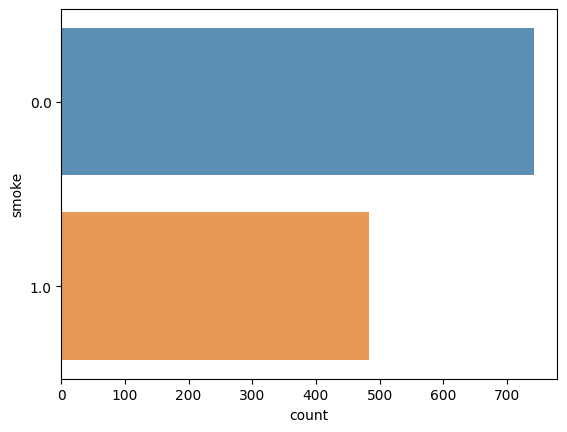

In [ ]:
sns.countplot(y="smoke", data=data, alpha=0.8)

<Axes: xlabel='count', ylabel='parity'>

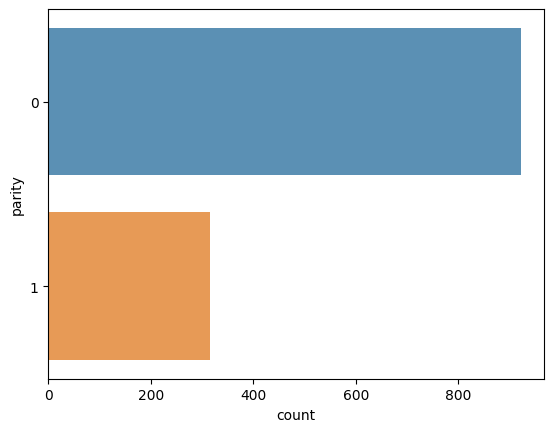

In [ ]:
sns.countplot(y="parity", data=data, alpha=0.8)

In [ ]:
data.isna().mean() * 100

case         0.000000
bwt          0.000000
gestation    1.051780
parity       0.000000
age          0.161812
height       1.779935
weight       2.912621
smoke        0.809061
dtype: float64

In [ ]:
data.drop(columns=['case'], inplace=True)

In [ ]:
data.columns

Index(['bwt', 'gestation', 'parity', 'age', 'height', 'weight', 'smoke'], dtype='object')

In [ ]:
cols = ['bwt', 'gestation', 'parity', 'age', 'height', 'weight', 'smoke']

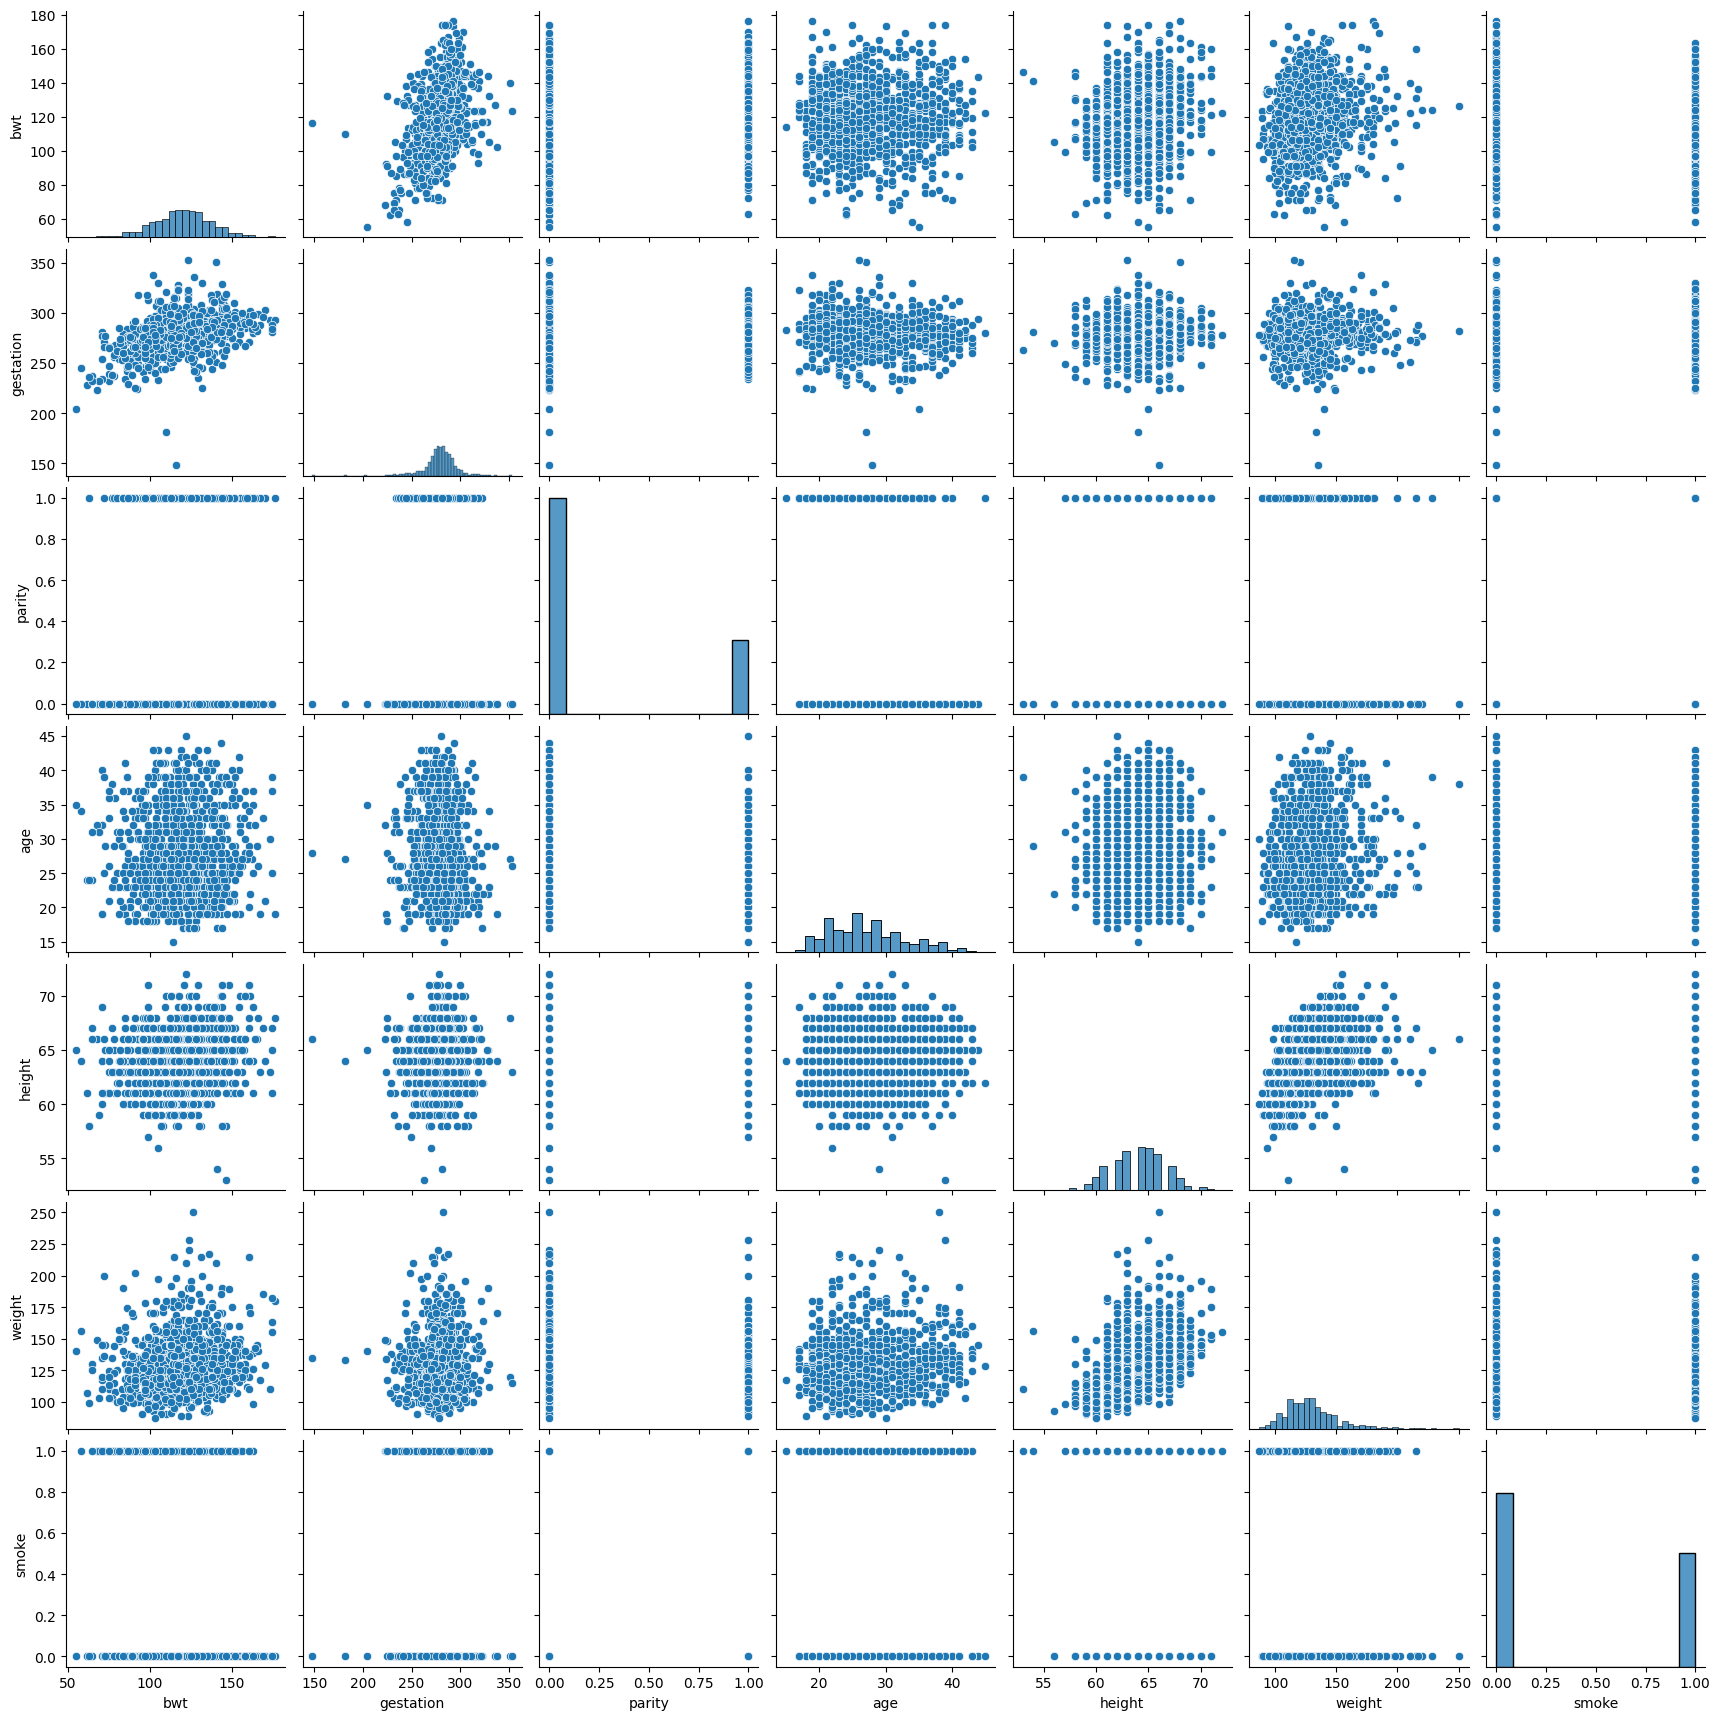

In [ ]:
sns.pairplot(data[cols])

<Axes: >

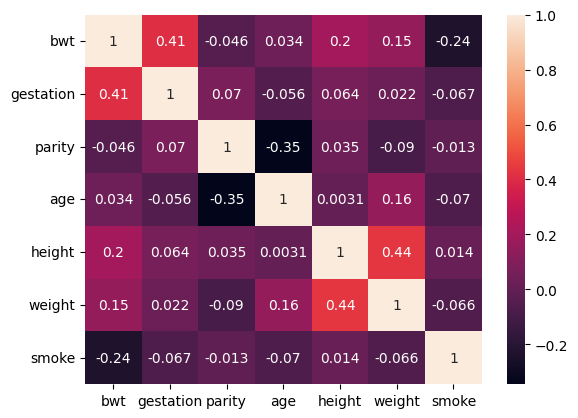

In [ ]:
sns.heatmap(data.corr(),annot=True)

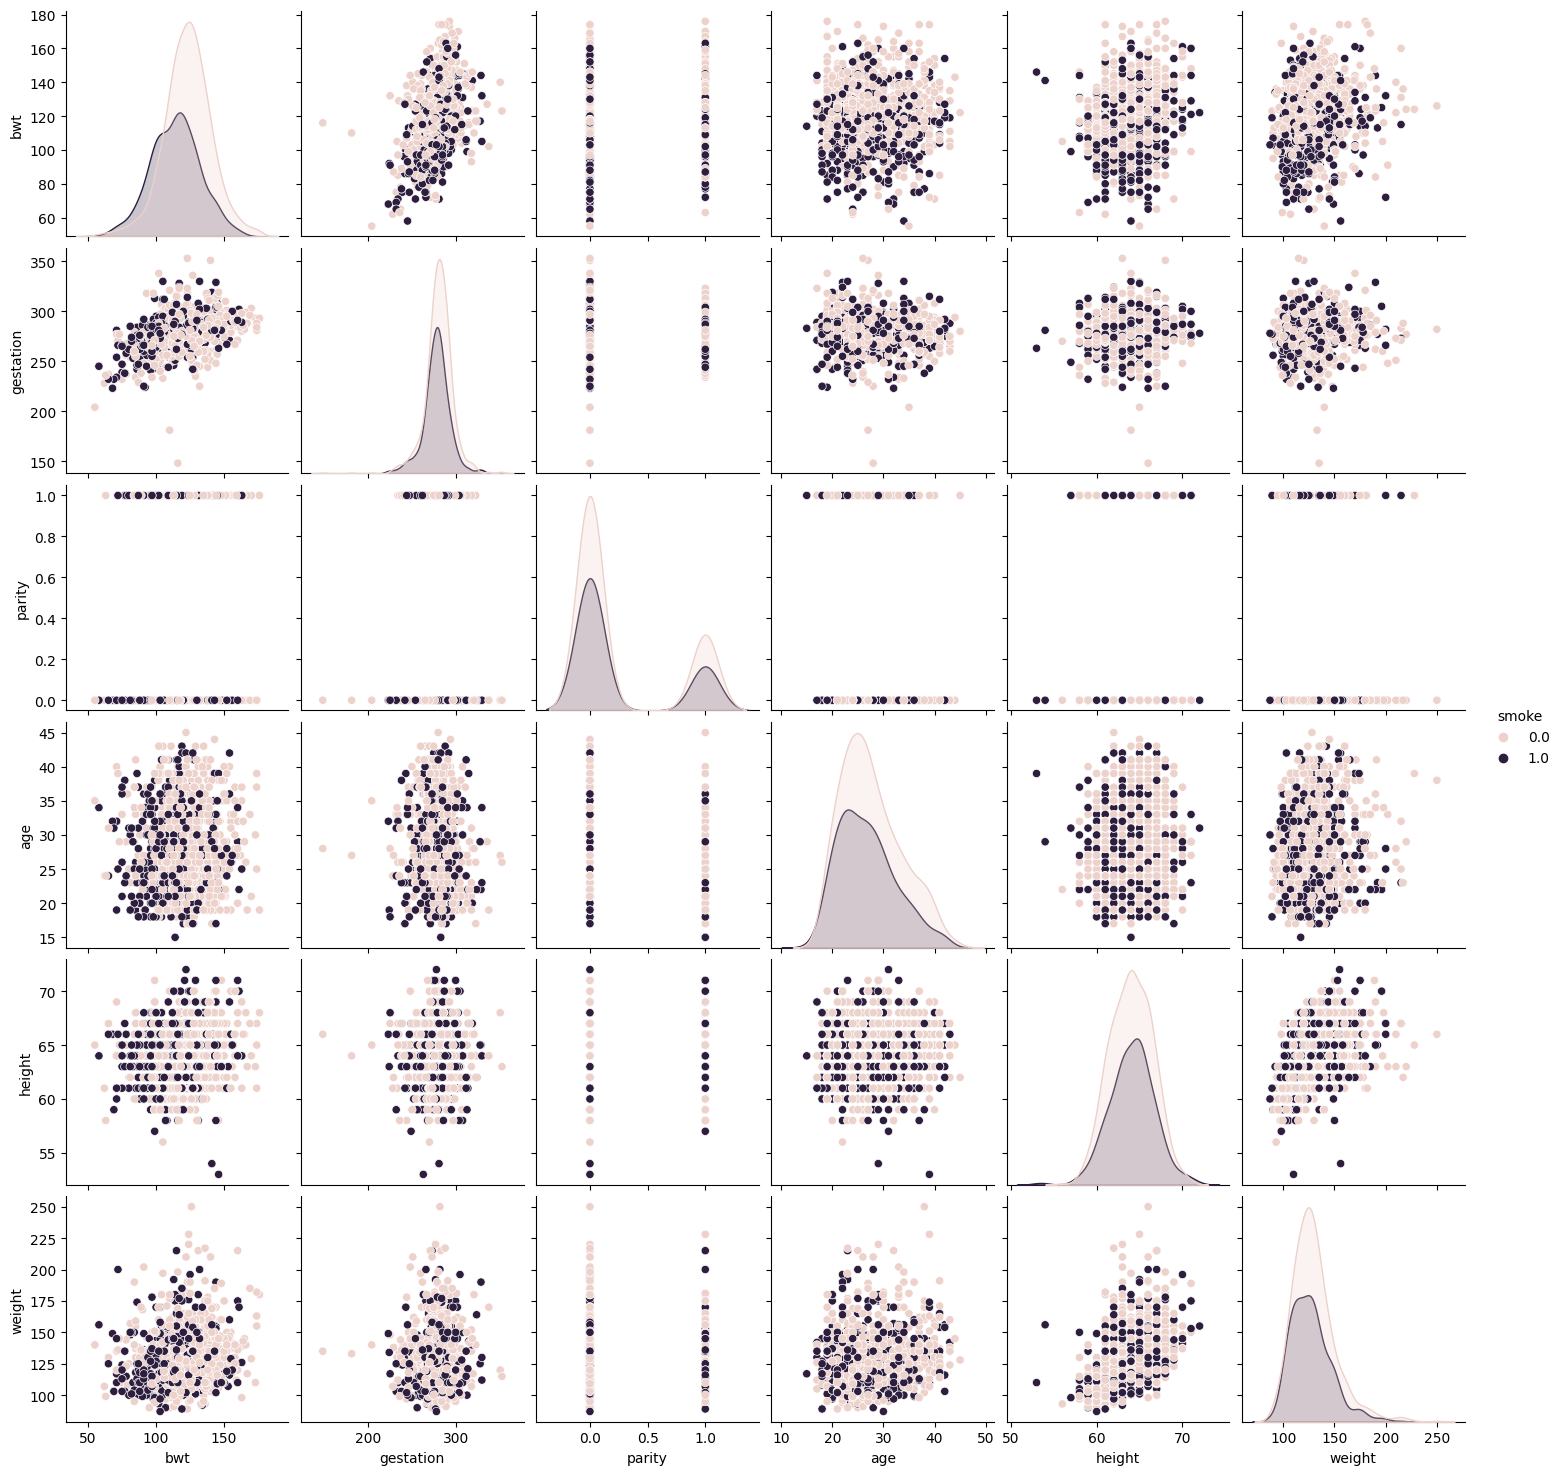

In [ ]:
sns.pairplot(data,hue='smoke')

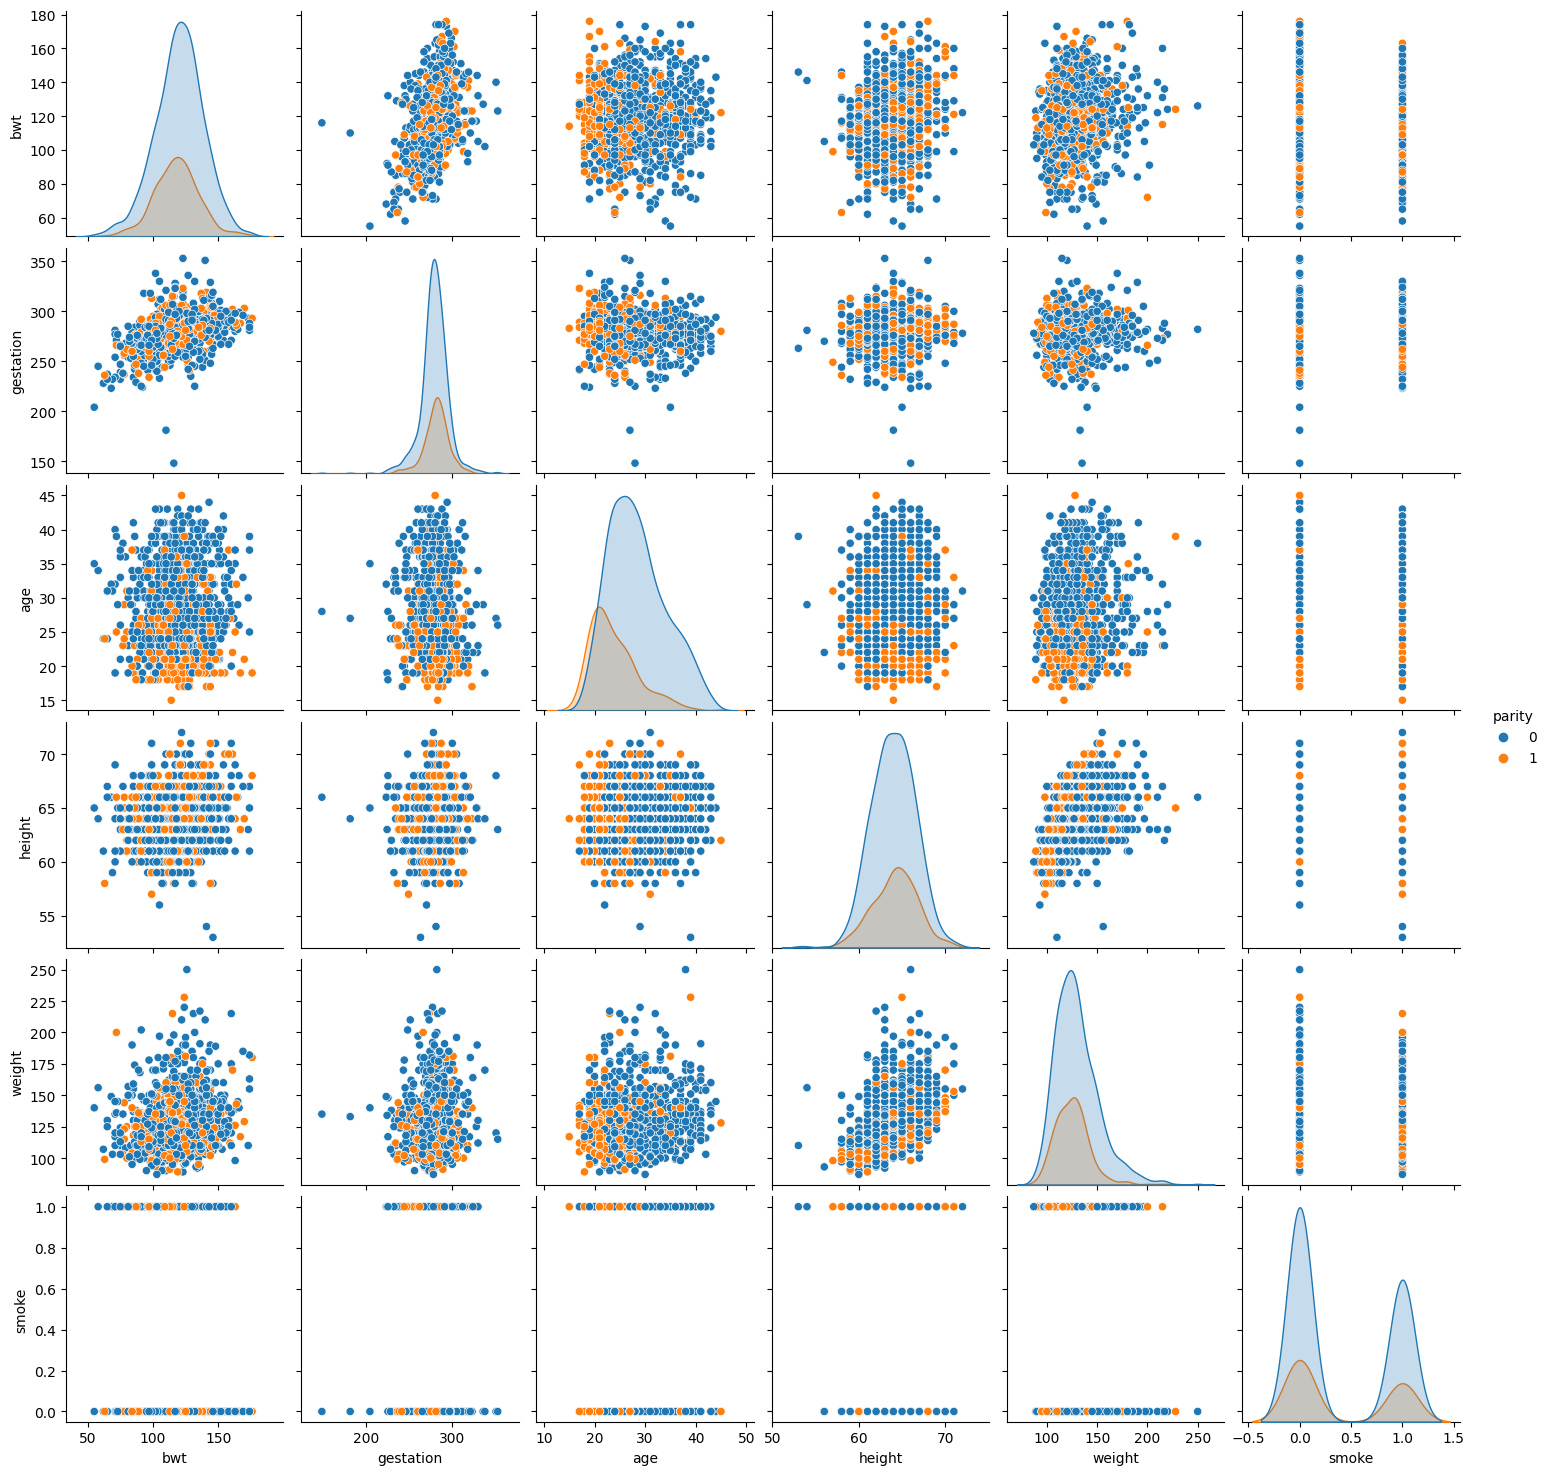

In [ ]:
sns.pairplot(data, hue='parity')

<Axes: xlabel='age', ylabel='bwt'>

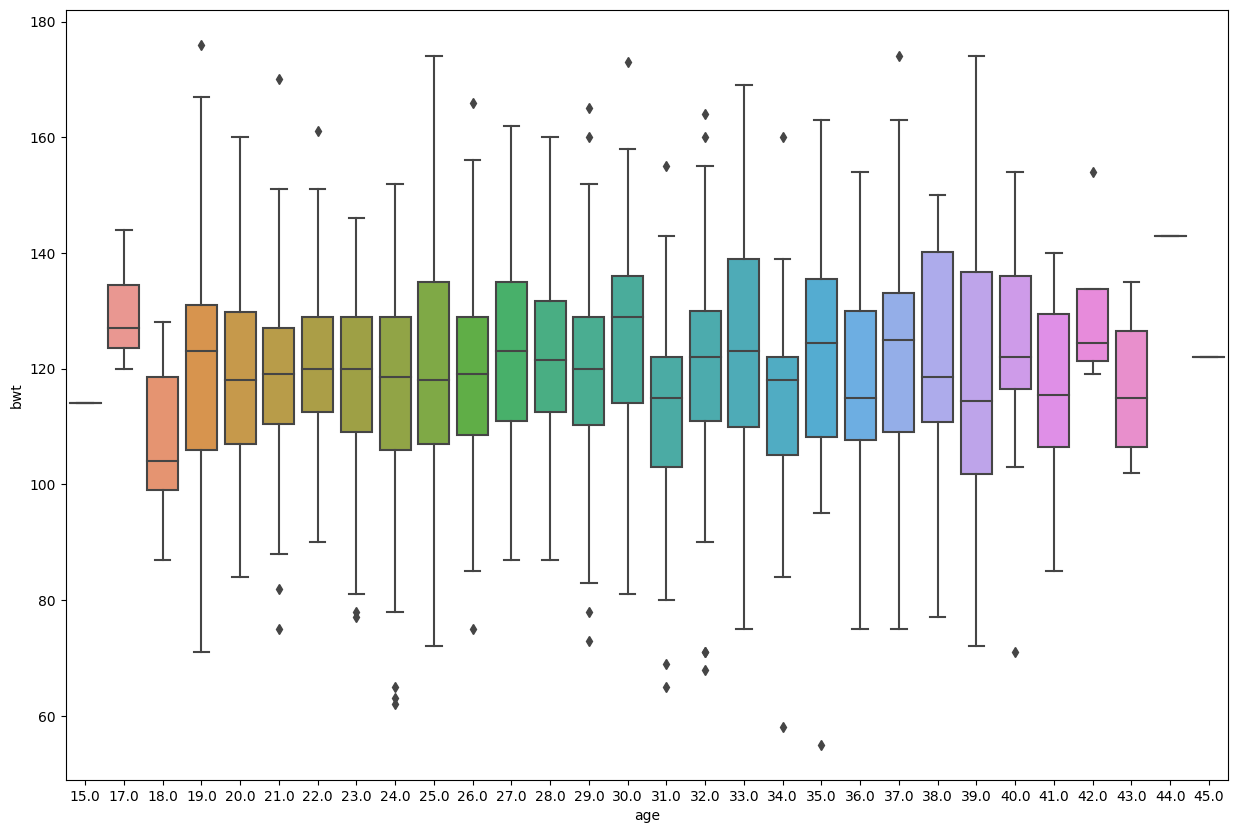

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x=data['age'],y=data['bwt'])

Больше всего коррелируют между собой срок беременности и вес ребенка при рождении, рост и вес матери. Логично, что рост, вес и возраст распределены нормально. Существенной разницы в характеристиках курящих и не курящих женщин нет.

In [ ]:
data['age'].fillna(data['age'].mean(), inplace = True)
data['gestation'].fillna(data['gestation'].mean(), inplace = True)
data['height'].fillna(data['height'].mean(), inplace = True)
data['weight'].fillna(data['weight'].mean(), inplace = True)
data['smoke'].fillna(0, inplace=True)

In [ ]:
X = data.drop('bwt',axis=1)
y = data['bwt']

# 2. Modeling

## 2.1 Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

271.3214765474915

In [ ]:
r_sq = lr.score(X_test, y_test)
r_sq

0.22230764795007807

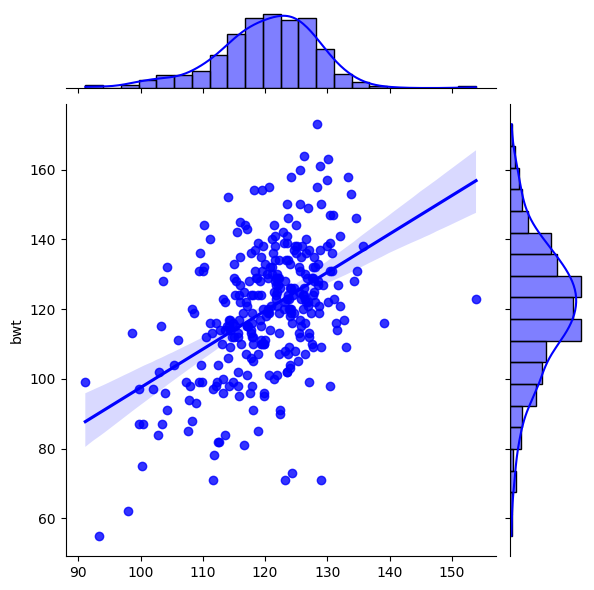

In [ ]:
sns.jointplot(
    x=lr.predict(X_test), y=y_test,
    kind='reg',
    color = 'blue',
    ci=95)

# 2.2 Logistic Regression

In [ ]:
X = data.drop('parity',axis=1)
y = data['parity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.8, random_state = 1)

In [ ]:
logreg_cv = LogisticRegression(random_state = 0)

In [ ]:
model = logreg_cv.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred 

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
model.score(X_test, y_test)

0.7580645161290323

In [ ]:
model.score(X_train, y_train)

0.7844129554655871

In [ ]:
param_grid = {
    'C': np.arange(1, 5, 100),
    'penalty': ['l1', 'l2'],
}

In [ ]:
clf = GridSearchCV(LogisticRegression(random_state = 0, solver='liblinear'), param_grid, cv = 3, verbose = 0, n_jobs = -1)

In [ ]:
best_model = clf.fit(X_train, y_train)

In [ ]:
best_model.score(X_test, y_test)

0.7580645161290323

In [ ]:
best_model.score(X_train, y_train)

0.7803643724696356

In [ ]:
print(best_model.best_estimator_)

LogisticRegression(C=1, penalty='l1', random_state=0, solver='liblinear')


In [ ]:
df_report = pd.DataFrame(columns = {'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
df_report['F1'] = f1_score(y_test, model.predict(X_test))
df_report['precision_0'] = precision_score(y_test, model.predict(X_test), pos_label = 0) 
df_report['precision_1'] = precision_score(y_test, model.predict(X_test), pos_label = 1)
df_report['recall_0'] = recall_score(y_test, model.predict(X_test), pos_label = 0)
df_report['recall_1'] = recall_score(y_test, model.predict(X_test), pos_label = 1)

df_report.index = ['LogisticRegression']

In [ ]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
LogisticRegression,0.72854,0.387755,0.778802,0.612903,0.933702,0.283582


In [ ]:
def metric_classifier(report_df, model, X_test, y_test, name):
  report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
  report['ROC-AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
  report['F1'] = f1_score(y_test, model.predict(X_test))
  report['precision_0'] = precision_score(y_test, model.predict(X_test), pos_label = 0) 
  report['precision_1'] = precision_score(y_test, model.predict(X_test), pos_label = 1)
  report['recall_0'] = recall_score(y_test, model.predict(X_test), pos_label = 0)
  report['recall_1'] = recall_score(y_test, model.predict(X_test), pos_label = 1)
  report.index = [name]
  report_df = report_df.append(report)
  return report_df


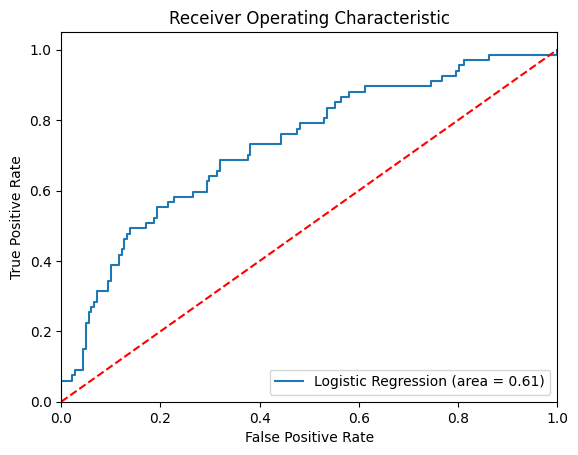

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# 2.3 Decision Tree

In [ ]:
X = data.drop('parity',axis=1)
y = data['parity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47, test_size = 0.25)

In [ ]:
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 50)

In [ ]:
model_tree = clf.fit(X_train, y_train)

In [ ]:
y_pred =  model_tree.predict(X_test)

print('Точность измерений (тренировочные данные): ', accuracy_score(y_true = y_train, y_pred = model_tree.predict(X_train)))
print('Точность измерений (тестовые данные): ', accuracy_score(y_true = y_test, y_pred = y_pred))

Точность измерений (тренировочные данные):  0.8284789644012945
Точность измерений (тестовые данные):  0.7443365695792881


In [ ]:
df_report = metric_classifier(df_report, model_tree, X_test, y_test, 'DecisionTree' )
df_report

<ipython-input-67-fc0a47ead7bd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append(report)


,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
LogisticRegression,0.728540,0.387755,0.778802,0.612903,0.933702,0.283582
DecisionTree,0.693313,0.396947,0.790698,0.509804,0.890830,0.325000


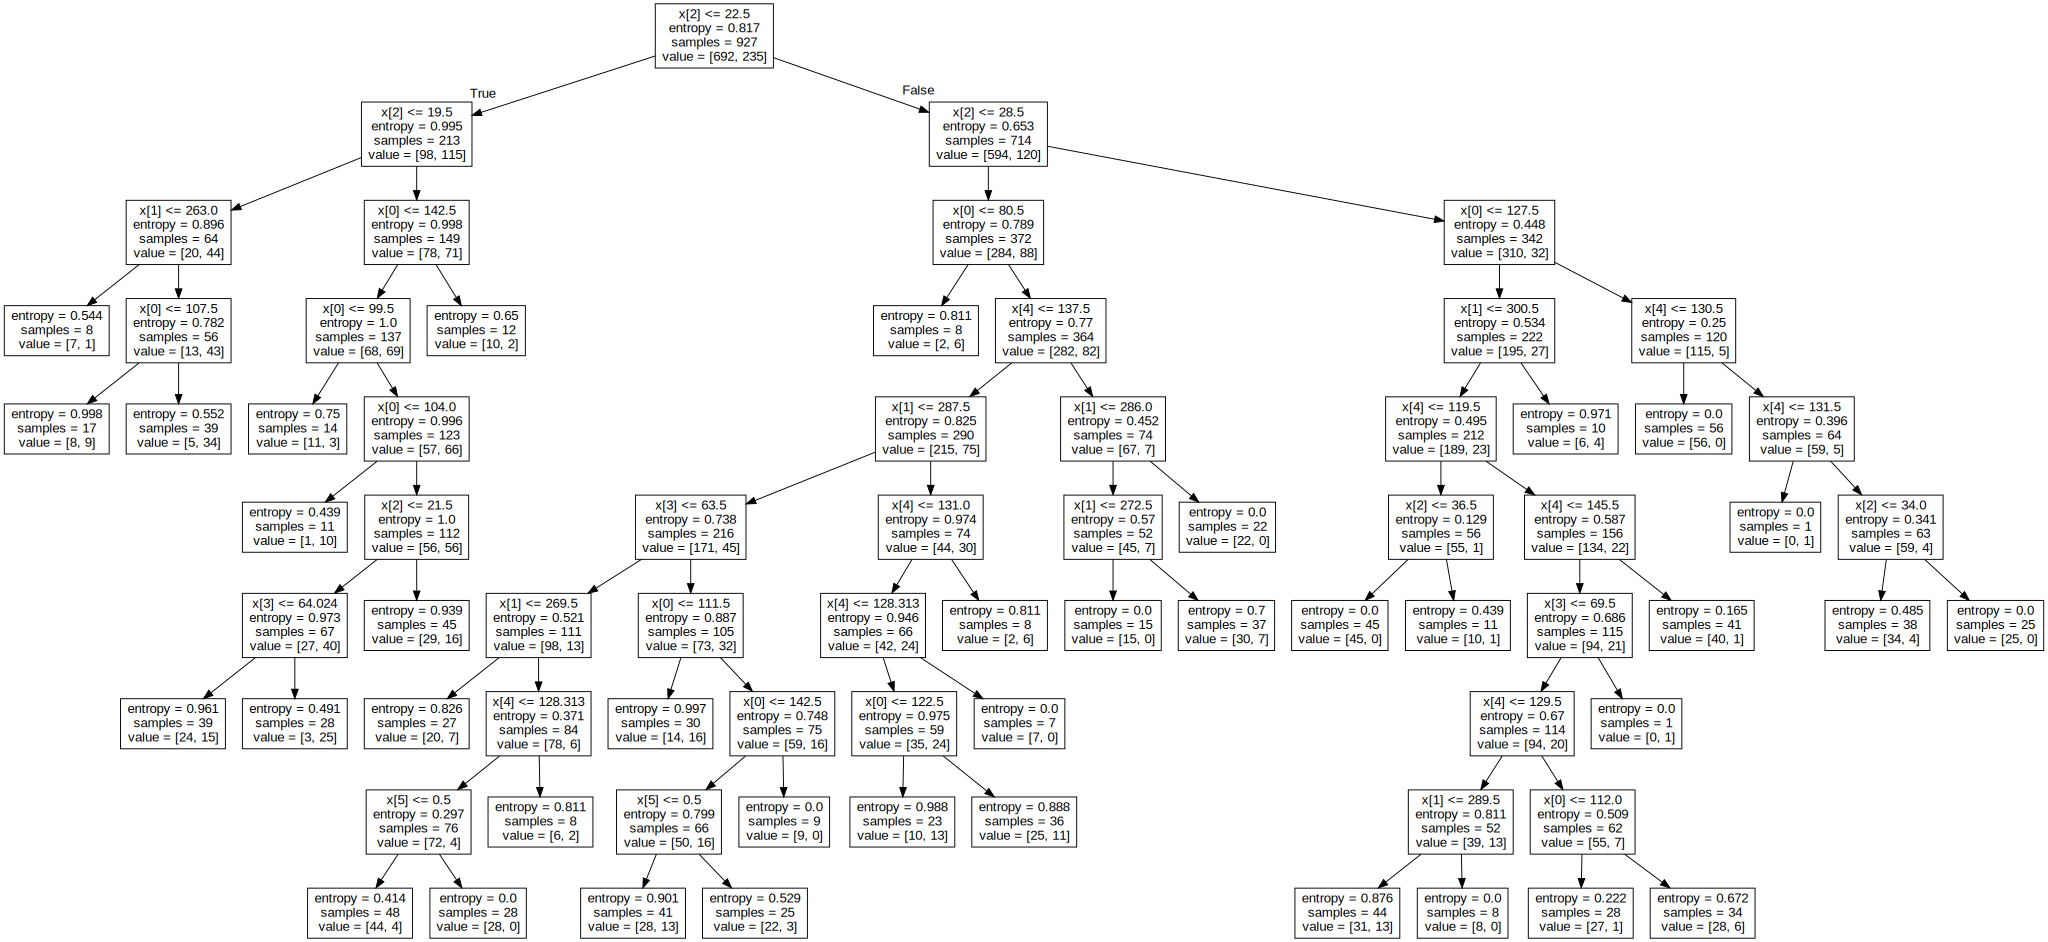

In [ ]:
dot_data = tree.export_graphviz(model_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph